
#### HA3 - Unsupervised Learning (Clustering)

GROUP 19  
Cátia Antunes (60494) - h<br>Donato Aveiro (46269) - h<br>Márcia Vital (59488) - h<br>Sean Gorman (59492) - h

In [ ]:
# Install the following packages if needed:
!pip install yellowbrick 

In [100]:
import pandas as pd
import numpy as np

from typing import List

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, spectral_clustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score,  homogeneity_completeness_v_measure, completeness_score, v_measure_score, precision_score, recall_score, homogeneity_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

Functions used in this notebook:

In [3]:
# Function that plots the elwbows for KMeans and KMeans++ for a given dataset and a list of Ks

def elbow_method(dataset: np.ndarray, K: List[int]) -> None:
    sum_of_squared_distances_KMEANS = []
    sum_of_squared_distances_KMEANSPP = []
    
    for k in K:
        km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=300, random_state=0)
        km = km.fit(dataset)
        sum_of_squared_distances_KMEANS.append(km.inertia_)

    for k in K:
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
        km = km.fit(dataset)
        sum_of_squared_distances_KMEANSPP.append(km.inertia_)
    
    # set size of plot
    plt.figure(figsize=(5, 5))
    plt.plot(K, sum_of_squared_distances_KMEANS, 'bx-', label='KMeans')
    plt.plot(K, sum_of_squared_distances_KMEANSPP, 'ro-', label='KMeans++')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Sum of squared distances')
    plt.title('Elbow Method')
    plt.legend(loc='best')
    plt.show()


In [4]:
# Function that plots the silhouette scores for KMeans and KMeans++ for a given dataset and a list of Ks

def plot_elbow_scores(dataset: np.ndarray, k: List[int]) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Distortion Score Elbow For Optimal k - TRAIN DATA')
    ax1.set_title('KMEANS')
    ax2.set_title('KMEANS++')

    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=0)
    visualizer_KMEANS = KElbowVisualizer(km, k=(1,20), ax=ax1)
    visualizer_KMEANS.fit(dataset)

    km_PP = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
    visualizer_KMEANSPP = KElbowVisualizer(km_PP, k=(1,20), ax=ax2)
    visualizer_KMEANSPP.fit(dataset)

    print("KMEANS:")
    print("Elbow value:", visualizer_KMEANS.elbow_value_)
    print("Elbow score:", visualizer_KMEANS.elbow_score_)
    print("KMEANS++:")
    print("Elbow value:", visualizer_KMEANSPP.elbow_value_)
    print("Elbow score:", visualizer_KMEANSPP.elbow_score_)
    
    #return (visualizer_KMEANS.elbow_value_, visualizer_KMEANS.elbow_score_, visualizer_KMEANSPP.elbow_value_, visualizer_KMEANSPP.elbow_score_)


In [5]:
# Function that compares the different clustering algorithms for a given dataset and a given K (THIS FUNCTION NEEDS TO BE UPDATED WITH ALGO SETTINGS NOT TESTED YET)

def compare_datasets_clustering(datasets, K=3, eps=0.5, min_samples=5, n_clusters=[7, 2, 7], linkage='ward', random_state=42):
    """
    Compare different clustering algorithms for multiple datasets.
    
    Args:
    datasets: a list of datasets to be compared, each dataset should be a pandas DataFrame
    K: the number of clusters to be used in KMeans clustering, default is 3
    eps: the maximum distance between two samples to be considered as in the same neighborhood in DBSCAN clustering, default is 0.5
    min_samples: the number of samples in a neighborhood for a point to be considered as a core point in DBSCAN clustering, default is 5
    n_clusters: the number of clusters to be used in AgglomerativeClustering and GaussianMixture clustering, default is [7, 2, 7]
    linkage: the linkage criterion to be used in AgglomerativeClustering, default is 'ward'
    random_state: the random state to be used in the different clustering algorithms, default is 42
    
    Returns:
    A pandas DataFrame with the Silhouette scores for each clustering algorithm applied to each dataset
    """
    
    # Initialize results dataframe
    algorithms = ['KMeans++', 'DBSCAN', 'Agglomerative Clustering', 'Hierarchical Clustering', 'Gaussian Mixture Model']
    columns = ['Dataset'] + algorithms
    results = pd.DataFrame(columns=columns)

    # Apply different clustering algorithms to each dataset
    for i, data in enumerate(datasets):
        
        #KMeans++
        kmeans = KMeans(n_clusters=K, init='k-means++', n_init=10, max_iter=100, random_state=random_state)
        kmeans.fit(data)

        # DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(data)

        # Agglomerative Clustering
        agg = AgglomerativeClustering(n_clusters=n_clusters[0], linkage=linkage)
        agg.fit(data)

        # Hierarchical Clustering
        hc = AgglomerativeClustering(n_clusters=n_clusters[1], linkage='ward')
        hc.fit(data)

        # Gaussian Mixture Model
        gmm = GaussianMixture(n_components=n_clusters[2], random_state=random_state)
        gmm.fit(data)

        # Add to results dataframe
        row = [f'Dataset {i+1}'] + [round(silhouette_score(data, model.labels_), 2) for model in [kmeans, dbscan, agg, hc, gmm]]
        results.loc[len(results)] = row
    
    return results


In [6]:
# Function that compares the different clustering algorithms for a given dataset and a given K (THIS FUNCTION NEEDS TO BE UPDATED WITH ALGO SETTINGS NOT TESTED YET)

def run_clustering_algorithms(dataset_1, dataset_2, dataset_3, k=3):
    
    datasets = [dataset_1, dataset_2, dataset_3]
    results_list = []
    
    for dataset in datasets:
        # KMeans
        kmeans = KMeans(n_clusters= k, n_init=10, max_iter=100, random_state=42)
        kmeans.fit(dataset)

        #DBSCAN
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        dbscan.fit(dataset)

        # Agglomerative Clustering
        agg = AgglomerativeClustering(n_clusters=7)
        agg.fit(dataset)

        # Hierarchical Clustering
        hc = AgglomerativeClustering(n_clusters=2, linkage='ward')
        hc.fit(dataset)

        # Gaussian Mixture Model
        gmm = GaussianMixture(n_components=7, random_state=42)
        gmm.fit(dataset)

        # Compute Silhouette scores and add to results dataframe
        results = pd.DataFrame(columns=['KMeans', 'DBSCAN', 'Agglomerative Clustering', 'Hierarchical Clustering', 'Gaussian Mixture Model'])
        results.loc['Silhouette Score'] = [round(silhouette_score(dataset, kmeans.labels_), 2),
                                           round(silhouette_score(dataset, dbscan.labels_), 2),
                                           round(silhouette_score(dataset, agg.labels_), 2),
                                           round(silhouette_score(dataset, hc.labels_), 2),
                                           round(silhouette_score(dataset, gmm.predict(dataset)), 2)]
        results_list.append(results)

    # Concatenate the results for each dataset
    results_df = pd.concat(results_list, keys=['Dataset 1', 'Dataset 2', 'Dataset 3'])

    return results_df

In [59]:
# Function that loads the data and splits it into train and test sets?

def load_data(df):
    """Load the data with any number of consecutive features, starting in column 0, where last column is the category class"""
    # load the data from a data frame already loaded in memory
    nc = df.shape[1] # number of columns
    matrix = df.values # get values of dataframe
    table_X = matrix [:, 1:nc-2] # get features (first columns)
    table_y = matrix [:, nc-1] # get category class (last column)
    features_names = df.columns.values[1:nc-2] #get features names
    target = df.columns.values[nc-1] # get target name
    return df, table_X, table_y, features_names, target

In [118]:
# Function that plots the silhouette scores side by side ######### SHAMELESSLY STOLEN FROM TP BUT MODIFIED TO PRINT THE 3 PLOTS SIDE BY SIDE#########

def drawSilhouette(X, labels, header="", pos=111):
    y_lower =10
    clusters = list(set(labels))
    n_clusters = len(clusters)

    fig = plt.gcf()
    ax1 = fig.add_subplot(pos)
    ax1.set_xlim([-0.5, 1])
    ax1.set_ylim([0, len(X) + (n_clusters) * 3+ y_lower])
    sil_avg = silhouette_score(X, labels)
    silhouette_values = silhouette_samples(X, labels)
    for i, c in enumerate(clusters):
        cs_values = silhouette_values[labels == c]
        cs_values.sort()
        size_ci = cs_values.shape[0]
        y_upper = y_lower + size_ci
        color = cm.nipy_spectral(i / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cs_values, facecolor=color, edgecolor="k", alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_ci, str(c))
        y_lower = y_upper + 3
    ax1.set_title("Silhouette plot "+ header)
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Clusters")
    ax1.axvline(x=sil_avg, c="r", linestyle="--")

    ax1.set_yticks([])

    return ax1


## Objective 1: Clustering

Objective 1 - Clustering

    Using the data from the train.csv file determine the best clustering approach able to classify this dataset
    Using the data from the unique_m.csv file determine the best clustering approach able to classify this dataset
    compare both approaches in computational performance and clustering quality (using intrinsic methods)

WARNING: columns may have VERY different ranges. This should be handled adequately

In [44]:
# Load the data
train_df = pd.read_csv("train.csv")
unique_m_df = pd.read_csv("unique_m.csv")

In [43]:
# Print the first 5 rows of the train_df
train_df.head()
# 82 columns

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [45]:
# Print the first 5 rows of the unique_m_df
unique_m_df.head()# 88 columns

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,material
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,Ba0.2La1.8Cu1O4
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,Ba0.1La1.9Ag0.1Cu0.9O4
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Ba0.1La1.9Cu1O4
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,Ba0.15La1.85Cu1O4
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,Ba0.3La1.7Cu1O4


Removing the identifier column 
The last column (material) of the unique_m.csv file is simply a label or identifier for each sample, and it does not have any inherent properties or characteristics that relate to the superconducting properties of the material. As a result, it is not useful in analyzing or predicting the superconducting properties of the materials and can be safely discarded from the analysis

In [40]:
# Drop the identifiers (last column) from unique_m.csv
unique_m_df = unique_m_df.iloc[:, :-1]
unique_m_df.head() # 87 columns

,H,He,Li,Be,B,C,N,O,F,Ne,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


Removing the critical temperature
In this task, the objective is to cluster the superconductivity data based on the available features, which are the various materials properties (such as the atomic mass, atomic radius, and so on). The last column of the dataset, which contains the dependent variable (critical_temp), represents the temperature at which a superconductor becomes a superconductor. This value is not relevant for the clustering analysis because it is not used to group similar data points together based on their intrinsic similarity. Therefore, the last column should be removed from the dataset before performing the clustering analysis.

In [11]:
# Remove the dependent variable (critical_temp) from both datasets 
train_X = train_df.iloc[:, :-1]
unique_m_X = unique_m_df.iloc[:, :-1]

In [12]:
# Print the head of train_X
train_X.head() #81 columns

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.25,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.25,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.25,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809


In [13]:
# Print the head of the unique_m_X
unique_m_X.head() #86

,H,He,Li,Be,B,C,N,O,F,Ne,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


Merging the datasets
We can merge the two datasets because they correspond to the same data instances and contain complementary information. The train.csv file contains the values of various features (such as lattice parameters, atomic weights, and more) that are known to influence superconductivity. The unique_m.csv file contains additional material properties such as the chemical formula, which could provide more insight into the superconducting properties. Merging the two datasets can create a more complete picture of the factors that affect superconductivity and can potentially improve the accuracy of the analysis

In [14]:
# merge the two datasets
merged_X = pd.concat([train_X, unique_m_X], axis=1)
merged_X.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [15]:
print(merged_X.shape)

(21263, 167)


Scaling
Normalization helps to scale the data so that all features have similar ranges of values. If different features have different scales, then some features may dominate the analysis simply because they have larger values, and this may lead to biased results. Normalizing the data allows each feature to contribute equally to the analysis. The MinMaxScaler function from the scikit-learn library is used to scale the data to the range [0,1].

In [16]:
# Normalize the data using min-max scaling
scaler = MinMaxScaler()
train_X_scaled = scaler.fit_transform(train_X)
unique_m_X_scaled = scaler.fit_transform(unique_m_X)
merged_X_scaled = scaler.fit_transform(merged_X)

### K-Means (Optimisation)

K-means vs K-means++

Both are clustering algorithms used to group data points into distinct clusters. However, there is a significant difference between these two algorithms in the way they initialize their centroids.
K-means algorithm selects the initial centroids randomly, which can lead to suboptimal cluster formation. On the other hand, K-means++ algorithm improves the initial centroid selection by using a probabilistic approach.
In K-means++, the first centroid is selected randomly from the data points, and then subsequent centroids are selected based on their distance from the already selected centroids. Specifically, the probability of a data point being selected as the next centroid is proportional to the square of its distance from the nearest centroid that has already been chosen.
This process ensures that the centroids are well spread out and reduces the chances of the algorithm getting stuck in local optima. As a result, K-means++ often outperforms K-means in terms of clustering accuracy and convergence speed, especially when dealing with large datasets.

In summary, the main difference between K-means and K-means++ is the method used for selecting initial centroids. K-means uses random initialization, while K-means++ uses a more sophisticated probabilistic approach to select the initial centroids.

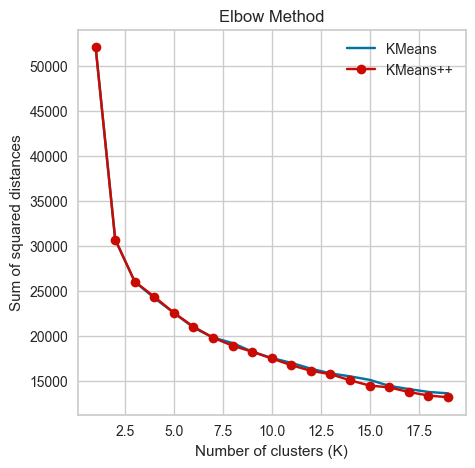

In [17]:
elbow_method(train_X_scaled, range(1, 20))

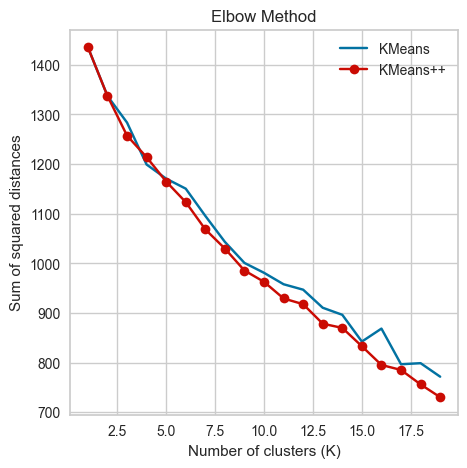

In [18]:
elbow_method(unique_m_X_scaled, range(1, 20))

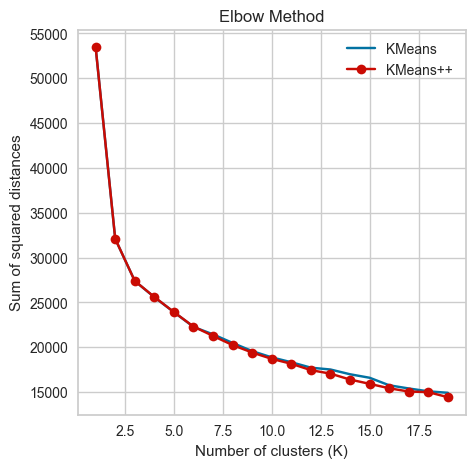

In [19]:
elbow_method(merged_X_scaled, range(1, 20))

K-Means: Bad elbows?

The elbow method is a commonly used technique for determining the optimal number of clusters in K-means clustering. The basic idea behind the elbow method is to plot the sum of squared distances (SSE) of the data points to their nearest cluster center against the number of clusters, and then look for an "elbow" in the plot where the SSE begins to level off. The idea is that the elbow point represents the point of diminishing returns, where adding more clusters does not result in a significant reduction in SSE.

While the elbow method can be a useful heuristic for selecting the number of clusters, it is not always clear where the elbow point is located, especially if the SSE plot does not exhibit a clear elbow. In such cases, it can be helpful to incorporate additional metrics to supplement the SSE plot. The silhouette score is one such metric that can be used to assess the quality of the clustering results.

The silhouette score measures how similar a data point is to its own cluster compared to other clusters. The score ranges from -1 to 1, with higher values indicating better cluster quality. A score of 1 indicates that the data point is very similar to its own cluster and very dissimilar to other clusters, while a score of -1 indicates the opposite. In the context of the elbow method, the silhouette score can be used to validate the clustering results obtained at each number of clusters. For example, if the elbow point occurs at 4 clusters, we can compute the silhouette score for each data point at k=4 and compare it to the scores at k=3 and k=5. If the silhouette score is significantly higher at k=4 than at k=3 or k=5, this provides additional evidence that 4 clusters is the optimal number.

Therefore, incorporating the silhouette score into the elbow method can help to provide additional information and validation of the optimal number of clusters, especially when the SSE plot is ambiguous.

https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d

KMEANS:
Elbow value: 3
Elbow score: 26042.953611995672
KMEANS++:
Elbow value: 3
Elbow score: 26042.953611995672


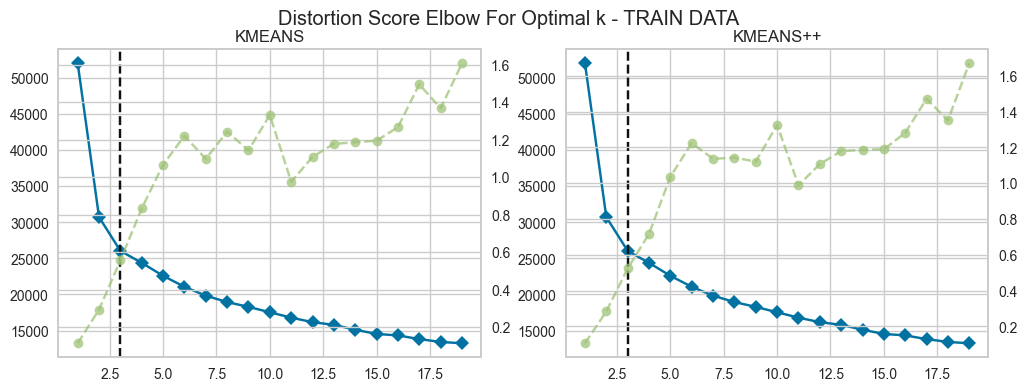

In [20]:
plot_elbow_scores(train_X_scaled, k =range(1, 20))

KMEANS:
Elbow value: 9
Elbow score: 985.6364493971757
KMEANS++:
Elbow value: 9
Elbow score: 985.6364493971757


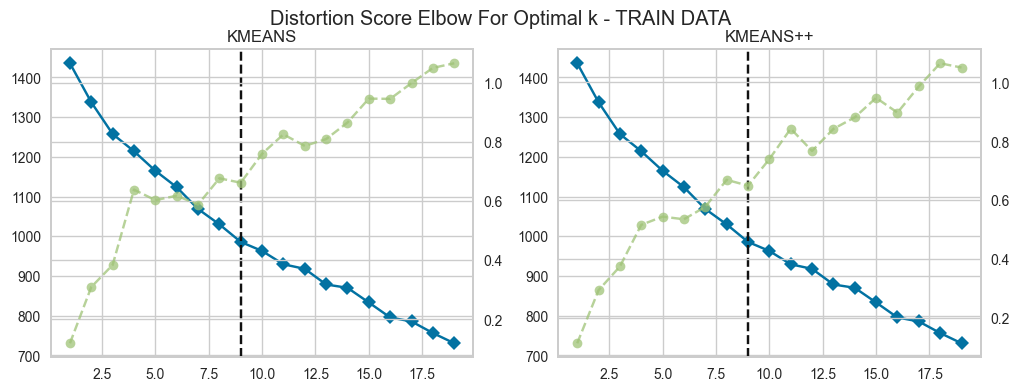

In [21]:
plot_elbow_scores(unique_m_X_scaled, range(1, 20))

KMEANS:
Elbow value: 3
Elbow score: 27397.430206646543
KMEANS++:
Elbow value: 3
Elbow score: 27397.430206646543


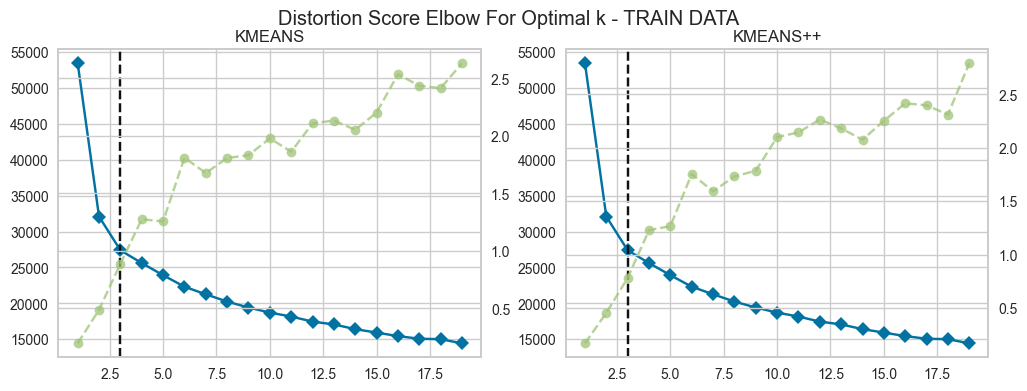

In [23]:
plot_elbow_scores(merged_X_scaled, range(1, 20))

KMEANS results

- For the dataset train_X_scaled, the optimal number of clusters is 3, based on the elbow method (With either K-means or K-means++)
- For the dataset unique_X_scaled, the optimal number of clusters is 9, based on the elbow method (With either K-means or K-means++).
- For the dataset merged_X_scaled, the optimal number of clusters is 3, based on the elbow method (With either K-means or K-means++).
- K-Means and K-Means++ perform similarly in terms of clustering quality, but K-Means++ is faster to converge.

### DBSCAN (Optimisation)

(to be continued)

### COMPARING CLUSTERING ALGORITHMS 
(Temporary results: this was not produced with the optimized settings)

In [72]:
run_clustering_algorithms(train_X_scaled, unique_m_X, merged_X, k=3)

,,KMeans,DBSCAN,Agglomerative Clustering,Hierarchical Clustering,Gaussian Mixture Model
Dataset 1,Silhouette Score,0.35,0.13,0.21,0.37,0.18
Dataset 2,Silhouette Score,0.89,0.23,0.43,0.89,-0.01
Dataset 3,Silhouette Score,0.52,-0.56,0.49,0.44,0.36


#### Comparison of Clustering Algorithms and datasets (TEMPORARY - THIS IS WITHOUT ALGO OPTIMIZATION)

The table shows the performance of different clustering algorithms on three different datasets, measured using the Silhouette score. The Silhouette score measures the quality of clustering, where a higher score indicates better clustering.

From the table, the following conclusions can be made:

    - KMeans and Hierarchical Clustering algorithms consistently perform well across all datasets, with Silhouette scores ranging from 0.21 to 0.89.

    - DBSCAN algorithm performs poorly compared to the other algorithms on all datasets, with Silhouette scores ranging from -0.56 to 0.23.

    - Agglomerative Clustering algorithm performs moderately on all datasets, with Silhouette scores ranging from 0.21 to 0.49.

    - Gaussian Mixture Model algorithm performs well on the train and merged datasets, but poorly on unique_m, where it achieves a negative Silhouette score.

Overall, KMeans and Hierarchical Clustering algorithms seem to be the most effective for these datasets based on the Silhouette score.

## Objective 2: Evaluating clustering with extrinsic methods

Objective 2 - Evaluating clustering with extrinsic methods

    Create the following Classes for the dependent variable (critical_temp):
        VeryLow - critical_temp in [0.0, 1.0,[
        Low - critical_temp in [1.0, 5.0,[
        Medium - critical_temp in [5.0, 20.0,[
        High - critical_temp in [20.0, 100.0,[
        VeryHigh - critical_temp in >= 100.0

    With the clusters produced in objective 2, using extrinsic methods, verify the quality of each model, for both the train.csv and the unique_m.csv clusters
    Discuss your results and compare them with the results of Objective 1 


If we assume K-Means++ performed better

First, the dependent variable (critical_temp) should be categorized into the specified classes (VeryLow, Low, Medium, High, and VeryHigh). This can be done by creating a new column in both the train.csv and the unique_m.csv files and assigning each data instance to the corresponding category based on its critical_temp value.

### 1. Creating classes for the dependent variable (critical_temp)

In [47]:
# Categorize critical_temp into specified classes by creating temperature classes for the train data and unique_m data

def categorize(temp):
    if temp < 1.0:
        return 'VeryLow'
    elif temp < 5.0:
        return 'Low'
    elif temp < 20.0:
        return 'Medium'
    elif temp < 100.0:
        return 'High'
    else:
        return 'VeryHigh'
    
# Remove the material column from unique_m_df
unique_m_df = unique_m_df.iloc[:, :-1]
    
# Add the category column to a copy of train_df and unique_m_df called train_df_cat and unique_m_df_cat

train_df_cat = train_df.copy() # create a copy of train_df
train_df_cat['category'] = train_df['critical_temp'].apply(categorize) # add new column to train_df_cat

unique_m_df_cat = unique_m_df.copy() # create a copy of unique_m_df
unique_m_df_cat['category'] = unique_m_df['critical_temp'].apply(categorize) # add new column to unique_m_df_cat


In [50]:
train_df_cat.head() # train df with the category column ### TO REMOVE LATER (JUST FOR PERSONAL VISUALIZATION) ###

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp,category
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0,High
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0,High
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0,Medium
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0,High
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0,High


In [52]:
unique_m_df_cat.head() # unique_m_df without the material col and with the category column added ### TO REMOVE LATER (JUST FOR PERSONAL VISUALIZATION) ###

,H,He,Li,Be,B,C,N,O,F,Ne,...,Au,Hg,Tl,Pb,Bi,Po,At,Rn,critical_temp,category
0,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,29.0,High
1,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,26.0,High
2,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,19.0,Medium
3,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,22.0,High
4,0.0,0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,23.0,High


In [70]:
# Loading the data to test quality of clustering algorithms
df_t, X_t, y_t, feature_names_t, target_t = load_data(train_df_cat)
df_u, X_u, y_u, feature_names_u, target_u = load_data(unique_m_df_cat)

### 2. Applying the clustering algos

In [91]:
# KMeans clustering for train_df (X_t)
K=3
kms_X_t = KMeans(n_clusters=K, n_init=10 ,random_state=0).fit(X_t)
kms_X_t.labels_  ### TO REMOVE LATER (JUST FOR PERSONAL VISUALIZATION) ###

array([1, 1, 1, ..., 2, 2, 2])

In [92]:
# KMeams clustering for unique_m_df (X_u)
K=9
kms_X_u = KMeans(n_clusters=K, n_init=10 ,random_state=0).fit(X_u)
kms_X_u.labels_ ### TO REMOVE LATER (JUST FOR PERSONAL VISUALIZATION) ###

array([1, 1, 1, ..., 2, 2, 2])

### 3. Evaluation of the clustering results using extrinsic methods

In [98]:
# Clustering results with Silhouette scores, Calinski-Harabasz scores, Homogeneity scores, Completeness scores, and V-measure scores

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, homogeneity_completeness_v_measure, completeness_score, v_measure_score, homogeneity_score

def print_clustering_results(X, y_pred, cluster_r):
    # Compute evaluation metrics
    sc = silhouette_score(X, cluster_r)
    chs = calinski_harabasz_score(X,cluster_r)
    print(f"Silhouette score: {sc:.4f}")
    print(f"Calinski-Harabasz score: {chs:.4f}")
    if y_pred is not None:
        hc = homogeneity_score(cluster_r, y_pred)
        cs = completeness_score(cluster_r, y_pred)
        vms = v_measure_score(cluster_r, y_pred)
        print(f"Homogeneity score: {hc:.4f}")
        print(f"Completeness score: {cs:.4f}")
        print(f"V-measure score: {vms:.4f}")


In [96]:
# Evaluating clustering results for train_df (X_t) - kms_X_t.labels_ 

print_clustering_results(X_t, kms_X_t.labels_ , y_t)

Silhouette score: 0.0038
Calinski-Harabasz score: 1956.0872
Homogeneity score: 0.2172
Completeness score: 0.3160
V-measure score: 0.2575


In [97]:
# Evaluating clustering results for unique_m_df (X_u) - kms_X_u.labels_
# Call the function to print the clustering results
print_clustering_results(X_u, kms_X_t.labels_, y_u)

Silhouette score: -0.0402
Calinski-Harabasz score: 274.0971
Homogeneity score: 0.2172
Completeness score: 0.3160
V-measure score: 0.2575


In [120]:
# Evaluating clustering results for unique_m_df (X_t) with the random model (random clustering)

N=len(X_t)
rand_clust_t = np.random.randint(K, size=N)

print_clustering_results(X_t, rand_clust_t, y_t)

Silhouette score: 0.0038
Calinski-Harabasz score: 1956.0872
Homogeneity score: 0.0004
Completeness score: 0.0002
V-measure score: 0.0003


In [121]:
# Evaluating clustering results for unique_m_df (X_u) with the random model (random clustering)

N=len(X_u)
rand_clust_u = np.random.randint(K, size=N)

print_clustering_results(X_u, rand_clust_u, y_u)


Silhouette score: -0.0402
Calinski-Harabasz score: 274.0971
Homogeneity score: 0.0007
Completeness score: 0.0004
V-measure score: 0.0006


### 4. Visualising the differences between the clustering results

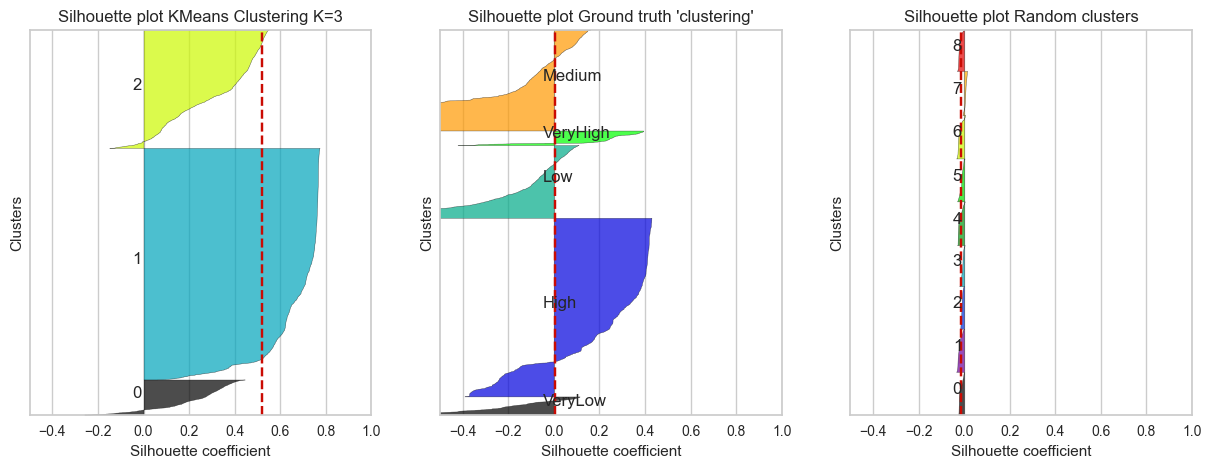

In [122]:
# Silhouette plots for train_df (X_t)

fig = plt.figure(figsize=(15, 5))
ax1 = drawSilhouette(X_t, kms_X_t.labels_, header="KMeans Clustering K=3", pos=131)
ax2 = drawSilhouette(X_t, y_t, header="Ground truth 'clustering'", pos=132)
ax3 = drawSilhouette(X_t, rand_clust_t, header="Random clusters", pos=133)
plt.show()


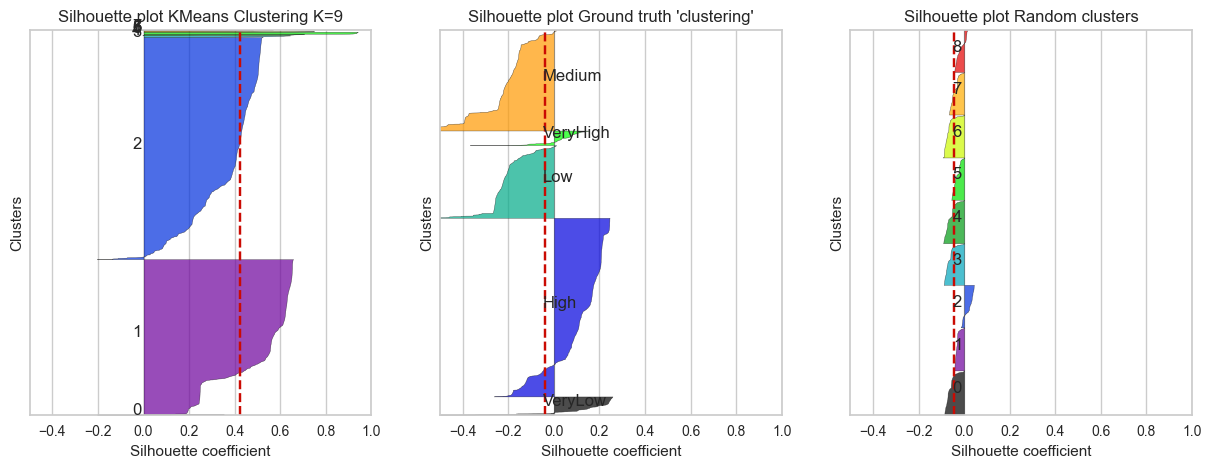

In [123]:
# Silhouette plots for train_df (X_u) 

fig = plt.figure(figsize=(15, 5))
ax1 = drawSilhouette(X_u, kms_X_u.labels_, header="KMeans Clustering K=9", pos=131)
ax2 = drawSilhouette(X_u, y_u, header="Ground truth 'clustering'", pos=132)
ax3 = drawSilhouette(X_u, rand_clust_u, header="Random clusters", pos=133)
plt.show()


### 5. Discussion of the results

Based on these results, it seems that the clustering algorithm did not perform well on either of the datasets. The Silhouette scores are both negative, indicating that many data points may have been assigned to the wrong cluster. The Calinski-Harabasz scores are also quite low, indicating that the clusters may not be well separated. The Homogeneity, Completeness, and V-measure scores are all the same for both datasets, which is surprising and may indicate an issue with the evaluation metric or clustering algorithm used. Overall, more investigation and experimentation with different clustering algorithms and parameter settings may be needed to improve the results.